## Bayes' and kNN classifier from scratch

In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling
import glob, os

### preparation
The code loads and reprojects Sentinel-2 bands and computes spectral indices: NDVI, NDBI, NDWI.These indices are used because they enhance biophysical properties such as vegetation greenness, built-up intensity, and moisture, providing features that are more discriminative for classification than raw spectral bands.

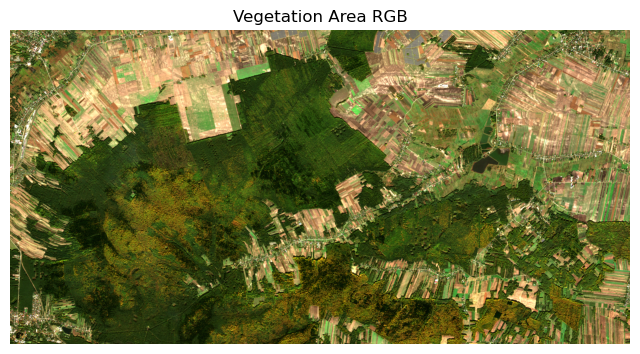

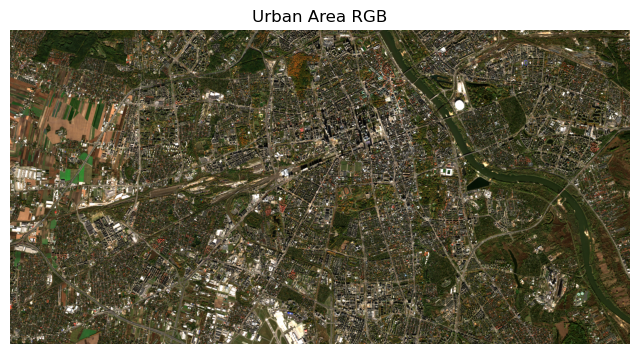

In [4]:
def match_band_to_ref(ref_path, folder, pattern):

    files = glob.glob(os.path.join(folder, pattern))
    src_path = files[0]

    with rasterio.open(ref_path) as ref:
        ref_profile = ref.profile
        dst = np.empty((ref.height, ref.width), dtype=np.float32)

        with rasterio.open(src_path) as src:
            reproject(
                source=rasterio.band(src, 1),
                destination=dst,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=ref.transform,
                dst_crs=ref.crs,
                dst_height=ref.height,
                dst_width=ref.width,
                resampling=Resampling.bilinear,
            )

    return dst

veg_ref = "vegetation.tif"
veg_folder = "vegetation_data"

V_B03 = match_band_to_ref(veg_ref, veg_folder, "*_B03_20m.jp2")   # Green
V_B04 = match_band_to_ref(veg_ref, veg_folder, "*_B04_20m.jp2")   # Red
V_B8A = match_band_to_ref(veg_ref, veg_folder, "*_B8A_20m.jp2")   # 8A because 08 is not available
V_B11 = match_band_to_ref(veg_ref, veg_folder, "*_B11_20m.jp2")   # SWIR

urb_ref = "urban.tif"
urb_folder = "urban_data"

U_B03 = match_band_to_ref(urb_ref, urb_folder, "*_B03_20m.jp2")
U_B04 = match_band_to_ref(urb_ref, urb_folder, "*_B04_20m.jp2")
U_B8A = match_band_to_ref(urb_ref, urb_folder, "*_B8A_20m.jp2")
U_B11 = match_band_to_ref(urb_ref, urb_folder, "*_B11_20m.jp2")

def ndvi(NIR, RED):
    return (NIR - RED) / (NIR + RED + 1e-6)

def ndbi(SWIR, NIR):
    return (SWIR - NIR) / (SWIR + NIR + 1e-6)

def ndwi(G, NIR):
    return (G - NIR) / (G + NIR + 1e-6)

V_NDVI = ndvi(V_B8A, V_B04)
V_NDBI = ndbi(V_B11, V_B8A)
V_NDWI = ndwi(V_B03, V_B8A)

U_NDVI = ndvi(U_B8A, U_B04)
U_NDBI = ndbi(U_B11, U_B8A)
U_NDWI = ndwi(U_B03, U_B8A)

with rasterio.open("vegetation.tif") as src:
    veg = src.read()

veg = veg.astype(np.float32)
veg /= np.percentile(veg, 99)
veg = np.clip(veg, 0, 1)

veg = np.transpose(veg, (1, 2, 0))

plt.figure(figsize=(8, 8))
plt.imshow(veg)
plt.title("Vegetation Area RGB")
plt.axis("off")
plt.show()

with rasterio.open("urban.tif") as src:
    urb = src.read()

urb = urb.astype(np.float32)
urb /= np.percentile(urb, 99)
urb = np.clip(urb, 0, 1)

urb = np.transpose(urb, (1, 2, 0))

plt.figure(figsize=(8, 8))
plt.imshow(urb)
plt.title("Urban Area RGB")
plt.axis("off")
plt.show()

### histograms
Then, I estimate Gaussian models for the distributions of NDVI, NDBI and NDWI in both vegetation and urban classes by computing their means and standard deviations, then overlays the corresponding normal PDFs on top of the empirical histograms. In the printed output, the values of μ and σ for each index and class provide the numerical parameters of these models.

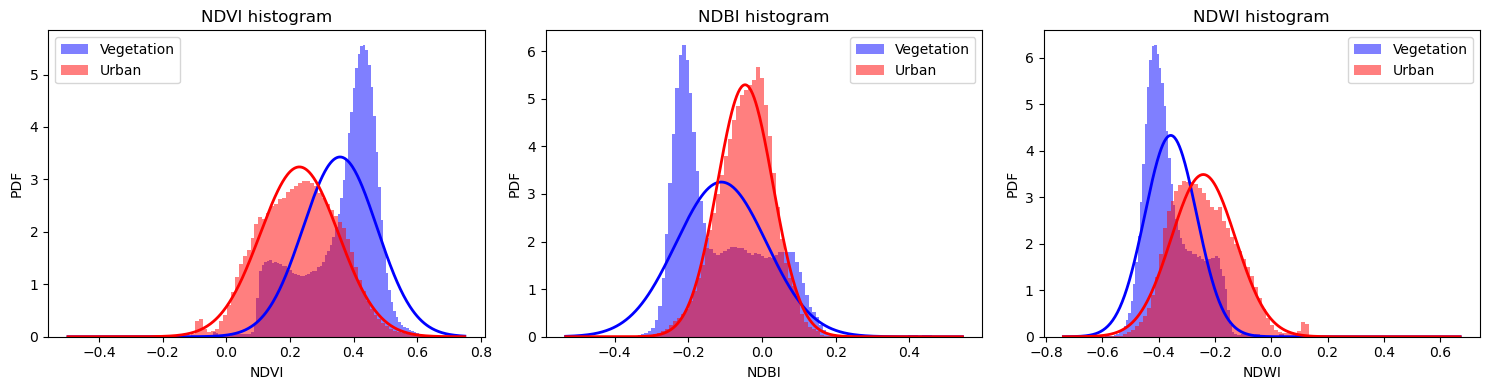


NDVI:
  Vegetation: μ = 0.3574, σ = 0.1164
  Urban     : μ = 0.2295, σ = 0.1232

NDBI:
  Vegetation: μ = -0.1103, σ = 0.1228
  Urban     : μ = -0.0459, σ = 0.0754

NDWI:
  Vegetation: μ = -0.3573, σ = 0.0921
  Urban     : μ = -0.2416, σ = 0.1143


In [12]:
def gaussian_pdf(x, mu, sigma):
    return (1.0 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

indices = [
    ("NDVI", V_NDVI, U_NDVI),
    ("NDBI", V_NDBI, U_NDBI),
    ("NDWI", V_NDWI, U_NDWI),
]

params = {} 

plt.figure(figsize=(15, 4))

for i, (name, veg, urb) in enumerate(indices, 1):
    veg_flat = veg.ravel()
    urb_flat = urb.ravel()

    veg_flat = veg_flat[~np.isnan(veg_flat)]
    urb_flat = urb_flat[~np.isnan(urb_flat)]

    mu_veg = np.mean(veg_flat)
    sigma_veg = np.std(veg_flat)

    mu_urb = np.mean(urb_flat)
    sigma_urb = np.std(urb_flat)

    params[name] = {
        "veg": (mu_veg, sigma_veg),
        "urb": (mu_urb, sigma_urb)
    }

    x_min = min(veg_flat.min(), urb_flat.min())
    x_max = max(veg_flat.max(), urb_flat.max())
    x = np.linspace(x_min, x_max, 500)

    plt.subplot(1, 3, i)
    plt.hist(veg_flat, bins=100, density=True, alpha=0.5, color='blue', label="Vegetation")
    plt.hist(urb_flat, bins=100, density=True, alpha=0.5, color='red', label="Urban")

    plt.plot(x, gaussian_pdf(x, mu_veg, sigma_veg), 'b-', linewidth=2)
    plt.plot(x, gaussian_pdf(x, mu_urb, sigma_urb), 'r-', linewidth=2)

    plt.title(f"{name} histogram")
    plt.xlabel(name)
    plt.ylabel("PDF")
    plt.legend()

plt.tight_layout()
plt.show()

for name, p in params.items():
    mu_v, sig_v = p["veg"]
    mu_u, sig_u = p["urb"]
    print(f"\n{name}:")
    print(f"  Vegetation: μ = {mu_v:.4f}, σ = {sig_v:.4f}")
    print(f"  Urban     : μ = {mu_u:.4f}, σ = {sig_u:.4f}")


### matrices
Feature matrices are constructed by stacking the indices into 3-dimensional feature vectors for every pixel. After flattening and combining the indices, any rows containing NaN values are removed.

In [ ]:
V_feat = np.vstack([
    V_NDVI.ravel(),
    V_NDBI.ravel(),
    V_NDWI.ravel()
]).T

U_feat = np.vstack([
    U_NDVI.ravel(),
    U_NDBI.ravel(),
    U_NDWI.ravel()
]).T

V_feat = V_feat[~np.isnan(V_feat).any(axis=1)]
U_feat = U_feat[~np.isnan(U_feat).any(axis=1)]

print("Vegetation sample number: ", V_feat.shape)
print("Urban sample number: ", U_feat.shape)

Vegetation sampe number:  (2172479, 3)
Urban sample number:  (1962096, 3)


### bayers 
First, it estimates for each class (vegetation and urban) a 3D Gaussian model by computing the mean vector and covariance matrix, and prepares their inverses and determinants for efficient evaluation of the log-likelihood. Then, for every pixel in the urban image it builds a 3D feature vector, computes the log-density under both class models, assigns the pixel to the class with higher log-probability, and visualizes the result as a classification map where red symbolize urban and blue symbolize vegetation.

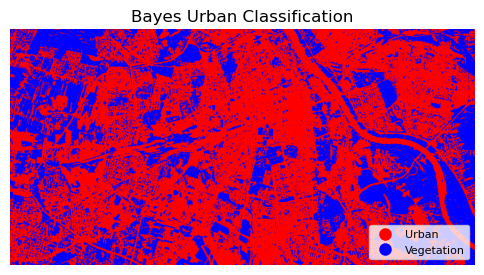

In [8]:
def gaussian(X):
    mu = X.mean(axis=0)
    Sigma = np.cov(X, rowvar=False)
    Sigma += np.eye(Sigma.shape[0]) * 1e-6
    return mu, Sigma

mu_veg, cov_veg = gaussian(V_feat)
mu_urb, cov_urb = gaussian(U_feat)

inv_veg = np.linalg.inv(cov_veg)
inv_urb = np.linalg.inv(cov_urb)
det_veg = np.linalg.det(cov_veg)
det_urb = np.linalg.det(cov_urb)

prior_veg = 0.5
prior_urb = 0.5

def log_gaussian_3d(x, mu, invC, detC):
    diff = x - mu
    return -0.5 * (
        np.log(detC + 1e-12)
        + diff @ invC @ diff.T
        + 3 * np.log(2 * np.pi)
    )
    
H, W = U_NDVI.shape
T_feat = np.dstack([U_NDVI, U_NDBI, U_NDWI]).reshape(-1, 3)

log_p_veg = np.array([log_gaussian_3d(x, mu_veg, inv_veg, det_veg) for x in T_feat])
log_p_urb = np.array([log_gaussian_3d(x, mu_urb, inv_urb, det_urb) for x in T_feat])

cls = (log_p_veg > log_p_urb).astype(np.uint8).reshape(H, W)  
class_rgb = np.zeros((H, W, 3), dtype=np.float32)
class_rgb[..., 0] = (cls == 0)
class_rgb[..., 2] = (cls == 1) 

plt.figure(figsize=(6, 6))
plt.imshow(class_rgb)
plt.title("Bayes Urban Classification")
plt.axis("off")
plt.legend(
    [
        plt.Line2D([0], [0], marker='o', color='red', markersize=8, linestyle=''),
        plt.Line2D([0], [0], marker='o', color='blue', markersize=8, linestyle='')
    ],
    ['Urban', 'Vegetation'],
    loc='lower right',
    fontsize=8,
    frameon=True
)
plt.show()


## KNN
Classifier first constructs labelled training data (1 = vegetation, 0 = urban), randomly samples 1000 training points, normalizes the features, and then for each test pixel computes Euclidean distances to all training samples, taking the majority class among the k closest neighbours. Finally, it repeats the classification for k = 1, 3 and 5, and visualizes results.

k = 1 ...
k = 3 ...
k = 5 ...


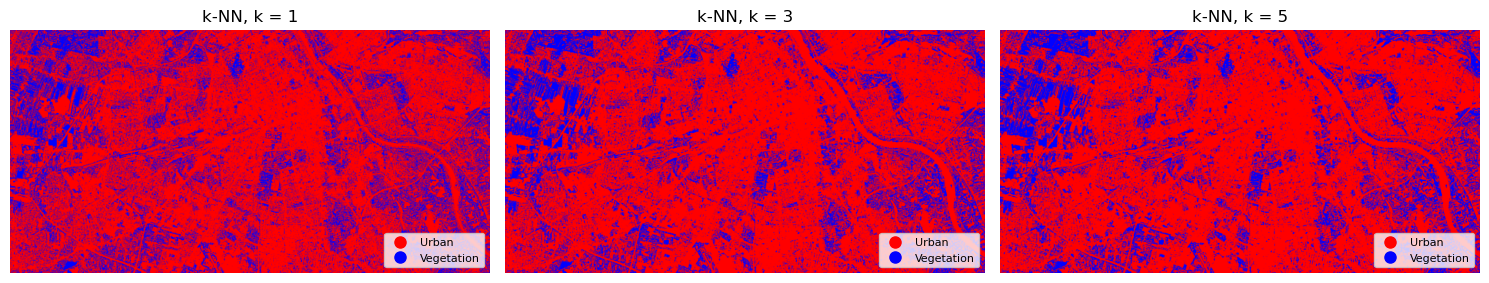

In [13]:

y_V = np.ones(V_feat.shape[0], dtype=np.uint8)
y_U = np.zeros(U_feat.shape[0], dtype=np.uint8)

X_train_full = np.vstack([V_feat, U_feat])
y_train_full = np.concatenate([y_V, y_U])

train_size = 1000  
idx = np.random.choice(X_train_full.shape[0], train_size, replace=False)

X_train = X_train_full[idx]
y_train = y_train_full[idx]

H, W = U_NDVI.shape
X_test = np.dstack([U_NDVI, U_NDBI, U_NDWI]).reshape(-1, 3)

mu = X_train.mean(axis=0)
std = X_train.std(axis=0) + 1e-6
X_train_n = (X_train - mu) / std
X_test_n  = (X_test  - mu) / std

def knn_predict(X_train, y_train, X_test, k):
    M = X_test.shape[0]
    y_pred = np.zeros(M, dtype=np.uint8)
    
    batch_size = 1000
    for start in range(0, M, batch_size):
        end = min(start + batch_size, M)
        X_batch = X_test[start:end] 
        diff = X_batch[:, None, :] - X_train[None, :, :]
        dist2 = np.sum(diff**2, axis=2)
        
        nn_idx = np.argsort(dist2, axis=1)[:, :k]
        nn_labels = y_train[nn_idx]
        
        y_batch = (np.mean(nn_labels, axis=1) >= 0.5).astype(np.uint8)
        y_pred[start:end] = y_batch
    
    return y_pred

k_values = [1, 3, 5]
class_maps = {}

for k in k_values:
    print(f"k = {k} ...")
    y_pred = knn_predict(X_train_n, y_train, X_test_n, k)
    class_maps[k] = y_pred.reshape(H, W)

plt.figure(figsize=(15, 5))

for i, k in enumerate(k_values, 1):
    cls = class_maps[k]
    rgb = np.zeros((H, W, 3), dtype=np.float32)
    rgb[..., 0] = (cls == 0)  # urban
    rgb[..., 2] = (cls == 1)  # vegetation
    
    plt.subplot(1, 3, i)
    plt.imshow(rgb)
    plt.title(f"k-NN, k = {k}")
    plt.legend(
        [
            plt.Line2D([0], [0], marker='o', color='red', markersize=8, linestyle=''),
            plt.Line2D([0], [0], marker='o', color='blue', markersize=8, linestyle='')
        ],
        ['Urban', 'Vegetation'],
        loc='lower right',
        fontsize=8,
        frameon=True
    )
    plt.axis("off")

plt.tight_layout()
plt.show()
